## Big data analytics: Big Data Bowl 
Authored by Jason Maloney and Jesse Pezzillo

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings; warnings.simplefilter('ignore')

In [2]:
# This dataset can be downloaded from https://www.kaggle.com/c/nfl-big-data-bowl-2020/data after an agreement is digitally signed through kaggle. 
data = pd.read_csv('train.csv')
#lower all columns
data.columns = map(str.lower, data.columns)

#### View the data and types

In [3]:
print(data.dtypes)

gameid                      int64
playid                      int64
team                       object
x                         float64
y                         float64
s                         float64
a                         float64
dis                       float64
orientation               float64
dir                       float64
nflid                       int64
displayname                object
jerseynumber                int64
season                      int64
yardline                    int64
quarter                     int64
gameclock                  object
possessionteam             object
down                        int64
distance                    int64
fieldposition              object
homescorebeforeplay         int64
visitorscorebeforeplay      int64
nflidrusher                 int64
offenseformation           object
offensepersonnel           object
defendersinthebox         float64
defensepersonnel           object
playdirection              object
timehandoff   

In [4]:
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


#### Player height

In [4]:
# create function to convert playerHeight to inches
def heightToInches(x):
    try:
        x,x1 = x.split('-')
        x = int(x)
        x1 = int(x1)
        x = (12*x) + x1
        return(x)
    except:
        return int(x*12)

In [5]:
# run function over column
data["playerheight"] = data["playerheight"].apply(heightToInches)

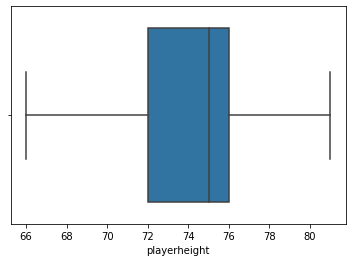

In [6]:
sns.boxplot(data["playerheight"])
plt.show()

#### Player age

In [7]:
# convert TimeHandoff to dates and times
data['timehandoff'] = pd.to_datetime(data['timehandoff'])
data['timesnap'] = pd.to_datetime(data['timesnap'])
data['playerbirthdate'] = pd.to_datetime(data["playerbirthdate"])
# confirm dtype
print('handoff time:',data["timehandoff"].dtype)
print('snap time:',data["timesnap"].dtype)
print('playerbirthdate',data["playerbirthdate"].dtype)

handoff time: datetime64[ns, UTC]
snap time: datetime64[ns, UTC]
playerbirthdate datetime64[ns]


In [8]:
# generate age of each player
def birthDayCalc(df):
    birthDay = df[0].year
    timeHandoff = df[1].year
    age = (timeHandoff - birthDay) 
    return age
data["age"] = data[["playerbirthdate","timehandoff"]].apply(birthDayCalc, axis=1)

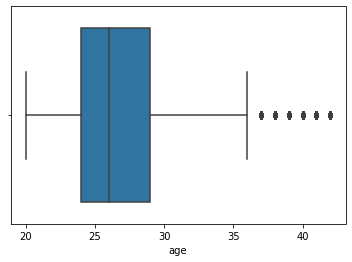

Player anomolies/Old dudes:


array(['Tom Brady', 'Josh McCown', 'Benjamin Watson', 'James Harrison',
       'Carson Palmer', 'Julius Peppers', 'Drew Brees', 'Terence Newman',
       'Antonio Gates', 'Dwight Freeney', 'Mike Adams', 'Philip Rivers',
       'Karlos Dansby', 'Eli Manning', 'Andrew Whitworth', 'Matt Schaub',
       'Cameron Wake', 'Ryan Fitzpatrick', 'Jason Peters',
       'Terrell Suggs', 'Jason Witten', 'Ben Roethlisberger'],
      dtype=object)

In [9]:
sns.boxplot(data["age"])
plt.show()
print("Player anomolies/Old dudes:")
data['displayname'][data["age"] > 36].unique()

#### Windspeed

In [10]:
# convert windspeed
def windConvert(x):
    try:
        x = re.match('[0-9]+',x)
        x = x.groups()
        for i in x:
            y += i
            return(y)
    except:
        return(x)
data["windspeed"] = data["windspeed"].apply(windConvert)
# set NAN to 0
#data["windspeed"] = data["windspeed"].fillna(value=0)
# set to integer
# data["windspeed"] = data["windspeed"].astype(int)

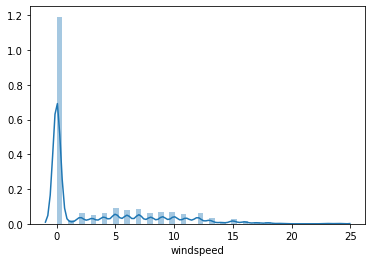

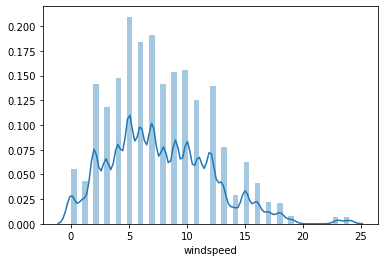

In [11]:
# plot with na's set to 0
sns.distplot(data["windspeed"].fillna(value=0))
plt.show()
# plot with no na's
sns.distplot(data["windspeed"].dropna())
plt.show()

In [12]:
# create a rusher dummy variable
data['rusher'] = 0
data['rusher'][data['nflid'] == data['nflidrusher']] = 1

#### Orientation and Direction

In [13]:
# create functions to fix oreintation and direction
# Refrenced this notebook to help understand how to modify https://www.kaggle.com/ben519/understanding-x-y-dir-and-orientation
def fixDir(x):
    y = (360-x+90) % 360
    return y
def fixOri(x):
    y = (360-x) % 360
    return y

In [14]:
# apply oreintation fix
data["orientation"][data["season"] == 2017] = data["orientation"][data["season"] == 2017].apply(fixOri)
# apply direction fix
data["dir"] = data["dir"].apply(fixDir)

#### Distance to the Rusher

In [15]:
# get Rusher X and Y
pos_df = pd.DataFrame(zip(data['x'][data['rusher'] == 1], data['y'][data['rusher'] == 1]), columns = ['x', 'y'])
pos_df.head()

,x,y
0,78.75,30.53
1,71.07,27.16
2,48.66,19.11
3,15.53,25.36
4,29.99,27.12


In [16]:
# need to get each value repeated 22 times, for each player in each play
posdf = pd.DataFrame(zip(pos_df['x'].repeat(22), pos_df['y'].repeat(22)), index = range(len(data)), columns = ['rushx', 'rushy'])
# put the rushX and rushY in the main df
data['rushx'] = posdf['rushx']
data['rushy'] = posdf['rushy']
del posdf # delete df to save memory

In [17]:
# euclidean dist = sqrt((x1 - x2)^2 + (y1 - y2)^2) - straight line distance
data['disttorush'] = np.sqrt((data['x'] - data['rushx'])**2 + (data['y'] - data['rushy'])**2)
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,gameweather,temperature,humidity,windspeed,winddirection,age,rusher,rushx,rushy,disttorush
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,278.01,272.82,...,Clear and warm,63.0,77.0,8.0,SW,29,0,78.75,30.53,6.480872
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,332.39,251.30,...,Clear and warm,63.0,77.0,8.0,SW,28,0,78.75,30.53,4.593310
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,356.99,247.27,...,Clear and warm,63.0,77.0,8.0,SW,28,0,78.75,30.53,5.448982
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,0.23,344.36,...,Clear and warm,63.0,77.0,8.0,SW,35,0,78.75,30.53,7.820038
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,347.37,285.69,...,Clear and warm,63.0,77.0,8.0,SW,30,0,78.75,30.53,10.622476


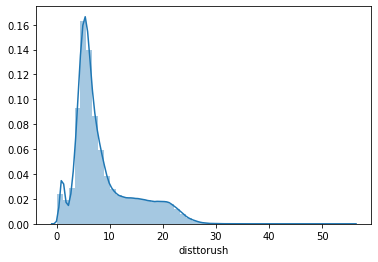

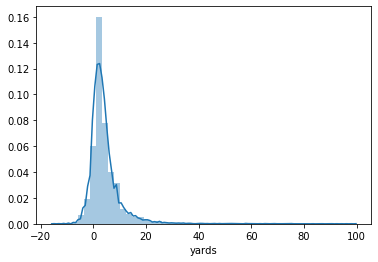

In [18]:
# distribution of players' distance to rusher
sns.distplot(data['disttorush'][data['rusher'] == 0])
plt.show()

# distribution of yards gained/play
sns.distplot(data['yards'])
plt.show()

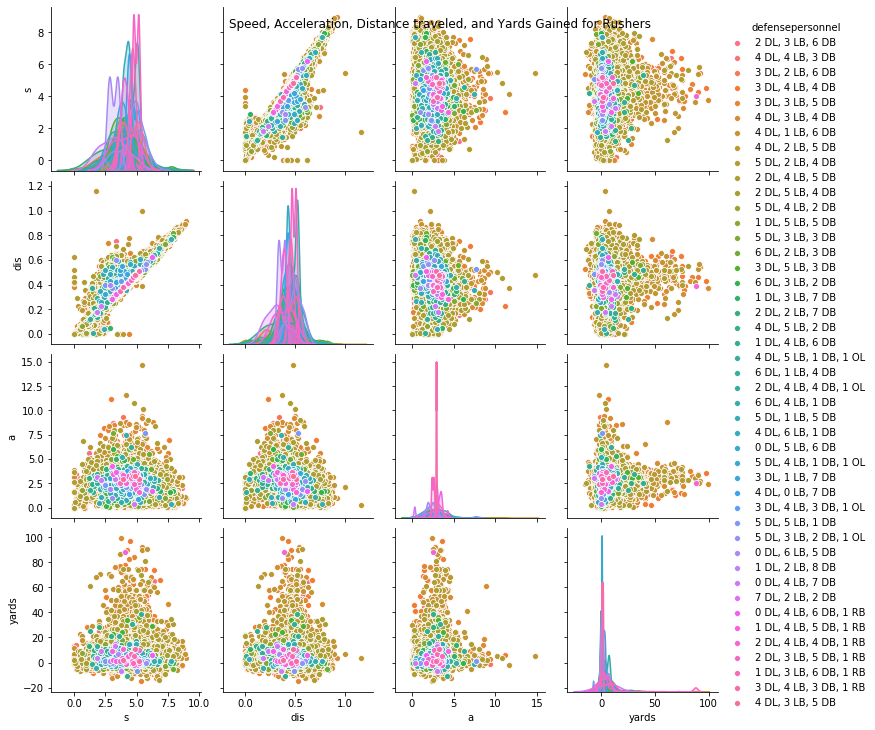

In [44]:
# Pair plot of speed, accleration, distance traveled, and yards gained
sns.pairplot(data.query("nflidrusher == nflid")[['s','dis','a','yards','defensepersonnel']],
            hue='defensepersonnel')
plt.suptitle('Speed, Acceleration, Distance traveled, and Yards Gained for Rushers')
plt.show()


#### Offensive and Defensive Personnel 

In [19]:
# count defensive position
# differentiate defensive ol and offensive ol - JM
data["ol_d"] = data["defensepersonnel"].str.extract(pat="([1-9] OL)")
data["ol_d"] = data["ol_d"].str.extract(pat="([1-9])")
data["dl"] = data["defensepersonnel"].str.extract(pat="([1-9] DL)")
data["dl"] = data["dl"].str.extract(pat="([1-9])")
data["lb"] = data["defensepersonnel"].str.extract(pat="([1-9] LB)")
data["lb"] = data["lb"].str.extract(pat="([1-9])")
data["db"] = data["defensepersonnel"].str.extract(pat="([1-9] DB)")
data["db"] = data["db"].str.extract(pat="([1-9])")
# differentiate defensive rb and offensive rb - JM
data["rb_d"] = data["defensepersonnel"].str.extract(pat="([1-9] RB)")
data["rb_d"] = data["rb_d"].str.extract(pat="([1-9])")

In [20]:
# count offensive position
# QB, OL, RB, TE, WR, DL, LB, DB
data['qb'] = data['offensepersonnel'].str.extract(pat='([1-9] QB)')
data['qb'] = data['qb'].str.extract(pat='([1-9])')
data['ol'] = data['offensepersonnel'].str.extract(pat='([1-9] OL)')
data['ol'] = data['ol'].str.extract(pat='([1-9])')
data['rb'] = data['offensepersonnel'].str.extract(pat='(\d RB)')
data['rb'] = data['rb'].str.extract(pat='(\d)')
data['te'] = data['offensepersonnel'].str.extract(pat='(\d TE)')
data['te'] = data['te'].str.extract(pat='(\d)')
data['wr'] = data['offensepersonnel'].str.extract(pat='(\d WR)')
data['wr'] = data['wr'].str.extract(pat='(\d)')
# differentiate offensive dl - JM
data['dl_o'] = data['offensepersonnel'].str.extract(pat='(\d DL)')
data['dl_o'] = data['dl_o'].str.extract(pat='(\d)')
data['lb_o'] = data['offensepersonnel'].str.extract(pat='(\d LB)')
data['lb_o'] = data['lb_o'].str.extract(pat='(\d)')
data['db_o'] = data['offensepersonnel'].str.extract(pat='(\d DB)')
data['db_o'] = data['db_o'].str.extract(pat='(\d)')

In [21]:
# replace nas with 0
data['ol'].fillna(0, inplace = True)
data['dl'].fillna(0, inplace = True)
data['db'].fillna(0, inplace = True)
data['lb'].fillna(0, inplace = True)
data['rb'].fillna(0, inplace = True)
data['ol_d'].fillna(0, inplace = True)
data['rb_d'].fillna(0, inplace = True)
data['te'].fillna(0, inplace = True)
data['wr'].fillna(0, inplace = True)
data['dl_o'].fillna(0, inplace = True)
data['lb_o'].fillna(0, inplace = True)
data['db_o'].fillna(0, inplace = True)
# replace qb nas with 1 - WILDCAT has a qb, but the ball is snapped to someone else - JM
data['qb'].fillna(1, inplace = True)

In [22]:
# set ol == 0 to be 11 - sum(offensive personnel)
off = ['rb', 'qb', 'te', 'wr', 'dl_o', 'lb_o', 'db_o'] 
data[off] = data[off].astype(str).astype(int)
data['ol'][data['ol'] == 0] = 11 - data[off].sum(axis = 1)

In [23]:
# convert rest of personnel to int
defp = ['dl', 'lb', 'rb_d', 'ol_d', 'db']
data[defp] = data[defp].astype(str).astype(int)
# fill lb na with 11 - sum(everyone else on defense)
data['lb'][data['lb'] == 0] = 11 - data[defp].sum(axis = 1)

In [24]:
data[13109:131114]

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,db,rb_d,qb,ol,rb,te,wr,dl_o,lb_o,db_o
13109,2017091100,20170911001375,home,11.24,23.79,2.01,0.47,0.25,327.89,254.16,...,5,0,1,5,1,1,3,0,0,0
13110,2017091100,20170911001375,home,10.57,37.71,0.02,0.04,0.00,351.54,226.16,...,5,0,1,5,1,1,3,0,0,0
13111,2017091100,20170911001375,home,16.84,35.15,1.62,2.13,0.26,253.33,282.32,...,5,0,1,5,1,1,3,0,0,0
13112,2017091100,20170911001543,away,86.15,30.79,0.52,1.04,0.10,176.06,17.13,...,5,0,1,5,1,1,3,0,0,0
13113,2017091100,20170911001543,away,91.23,30.00,1.98,0.50,0.24,103.77,358.09,...,5,0,1,5,1,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131109,2017110507,20171105073302,home,49.38,33.99,3.50,0.34,0.37,345.52,97.33,...,5,0,1,5,1,1,3,0,0,0
131110,2017110507,20171105073302,home,46.75,16.97,1.81,2.11,0.18,44.15,141.82,...,5,0,1,5,1,1,3,0,0,0
131111,2017110507,20171105073302,home,51.33,35.73,1.48,1.54,0.25,313.68,64.10,...,5,0,1,5,1,1,3,0,0,0
131112,2017110507,20171105073302,home,52.54,28.53,5.70,2.73,0.63,83.65,78.36,...,5,0,1,5,1,1,3,0,0,0


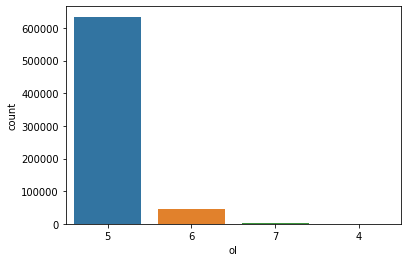

In [25]:
# distritbution of ol/play
sns.countplot(data['ol'])

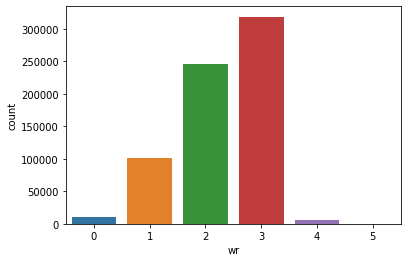

<function matplotlib.pyplot.show(*args, **kw)>

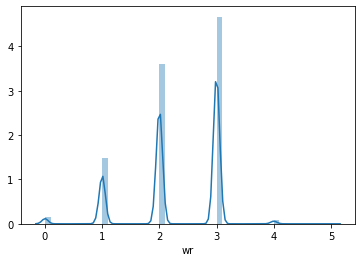

In [26]:
# distribution of wr/play
sns.countplot(data['wr'])
plt.show()

sns.distplot(data['wr'])
plt.show

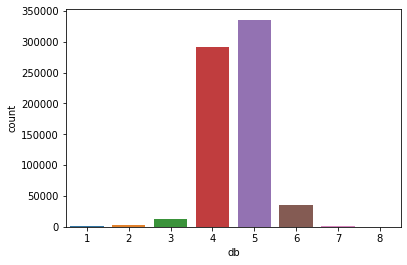

In [27]:
# distribution of db/play
sns.countplot(data['db'])

### Reshape dataframe

#### Function to Plot Football Field

In [182]:
import matplotlib.patches as patches
# los = line of scrimmage
'''
function defines default parameters that can be turned on/off
returns rectangle that resembles the field
bottom left corner is (0,0)

parameters: 
    turn on/off 
        - line numbers 
        - endzones
        - highlighted los
        - fifty yard line as default los
    highlight_los_number = yard line of los
'''
def plot_field(linenumbers = True, # show numbers on the field
              endzones = True, # can turn endzones on/off
              highlight_los = False, # show line of scrimmage
              highlight_los_number = 50, # default line of scrimmage = 50
              highlighted_name = 'Line of Scrimmage',
              fifty_is_los = False, # use default line of scrimmage
              figsize = (12, 5.33)): # 1/10 scale of the 120 x 53.3
    # define the rectangle that is the field
    field = patches.Rectangle((0,0), 120, 53.3, linewidth = 0.1,
                             edgecolor = 'red',
                             facecolor = 'green',
                             zorder = 0) # zorder = 0 - plot this first
    fig, ax = plt.subplots(1, figsize = figsize)
    # add the patch to the axes
    ax.add_patch(field)
    # define the field markers
    # first list is the x-coord, second is the y-coord 
    # the map together to plot vertical lines
    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120], 
            [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
            color = 'white')    
    # check for line of scrimmage
    if fifty_is_los:
        plt.plot([60,60], [0, 53.3], color = 'gold')
        plt.text(62, 50, '<- Line of Scrimmage', color = 'gold')
    # color the endzones so they stand out, if set to True
    if endzones:
        endzone1 = patches.Rectangle((0,0), 10, 53.3, # left endzone
                                    linewidth = 0.1,
                                    edgecolor = 'red',
                                    facecolor = 'yellow', # color of endzone
                                    alpha = 0.8, # transparency
                                    zorder = 0)
        endzone2 = patches.Rectangle((110,0), 120, 53.3, # right endzone
                                    linewidth = 0.1,
                                    edgecolor = 'red',
                                    facecolor = 'yellow',
                                    alpha = 0.8,
                                    zorder = 0)
        # add the patches to the endzones
        ax.add_patch(endzone1)
        ax.add_patch(endzone2)
        # set plot limits for the field
        plt.xlim(0, 120)
        plt.ylim(-5, 58.3) # a little extra padding on top and bottom
        plt.axis('off')
        # line numbers = True
        if linenumbers:
            for x in range(20, 110, 10): # start at the goalline and end on the goalline
                number = x
                # start with 20,30... once we get to midfield count backward
                if x > 50:
                    number = 120 - x
                # bottom numbers
                plt.text(x, 5, str(number - 10),
                        horizontalalignment = 'center',
                        fontsize = 20,
                        color = 'white')
                # top numbers
                plt.text(x - 0.95, 53.3 - 5, str(number - 10), # numbers are kind of off
                        horizontalalignment = 'center',
                        fontsize = 20,
                        color = 'white',
                        rotation = 180) # turn upside down to mimic a real field
    # set hash marks for middle of field and sidelines
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(0, 120)
    # print the hash marks on each yard line
    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color = 'white') #bottom sideline
        ax.plot([x, x], [53.0, 52.5], color = 'white') #top sideline
        ax.plot([x, x], [22.91, 23.57], color = 'white') # right hash - middle of field
        ax.plot([x, x], [29.73, 30.59], color = 'white') # left hash - middle of field
    # if highlight_los = True 
    if highlight_los:
        h1 = highlight_los_number + 10# account for the endzone
        plt.plot([h1, h1], [0, 53.3], 
                 color = 'gold') # define from bottom to top
        plt.text(h1 + 2, 50, '<- {}'.format(highlighted_name), 
                 color = 'gold')
    
    return fig, ax

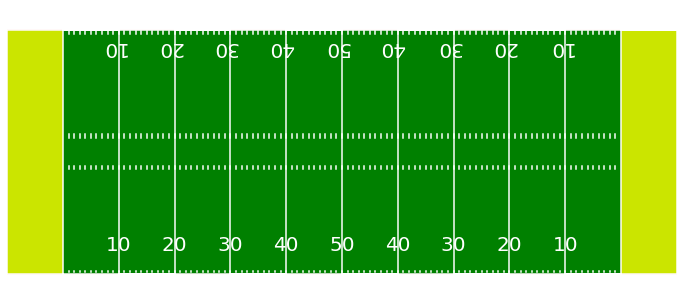

In [103]:
plot_field()
plt.show()

25


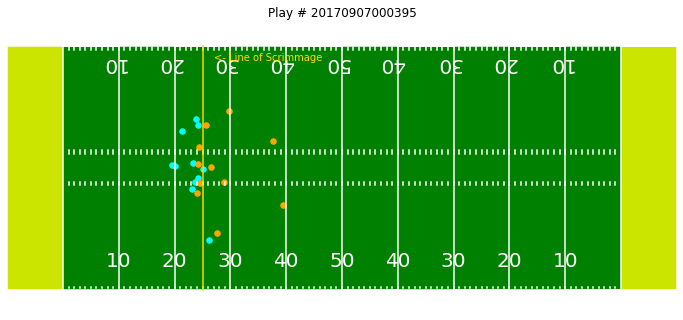

In [203]:
# plot a play
# left direction 20170907000118
# right direction 20170907000395

# highlight the line of scrimmage
los = data.loc[data['playid'] == 20170907000395]['yardline'].tolist()[0]
print(los)
fig, ax = plot_field(highlight_los = True,
                    highlight_los_number = los)
# away team
data.loc[(data['playid'] == 20170907000395)&(data['team'] == 'away')].plot(
    x = 'x_standard', 
    y = 'y_standard', 
    kind = 'scatter', 
    ax = ax, 
    color = 'cyan',
    s = 30, 
    legend = 'Away')
# home team
data.loc[(data['playid'] == 20170907000395)&(data['team'] == 'home')].plot(
    x = 'x_standard',
    y = 'y_standard',
    kind = 'scatter',
    ax = ax,
    color = 'orange',
    s = 30,
    legend = 'Home')
plt.title('Play # 20170907000395')
plt.show()

25


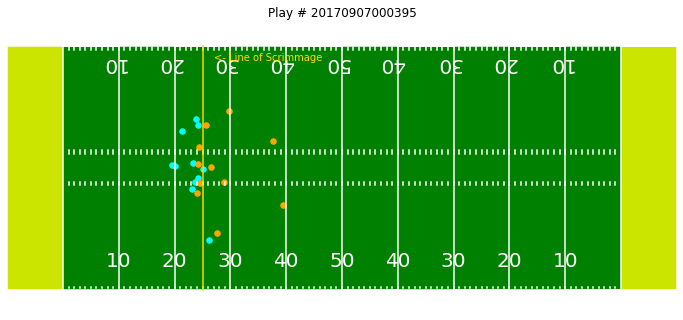

In [202]:
# plot a play 
# left direction 20170907000118
# right direction 20170907000395

# highlight the line of scrimmage
los = data.loc[data['playid'] == 20170907000395]['yardline'].tolist()[0]
print(los)
fig, ax = plot_field(highlight_los = True,
                    highlight_los_number = los)
# away team
data.loc[(data['playid'] == 20170907000395)&(data['team'] == 'away')].plot(
    x = 'x',
    y = 'y', 
    kind = 'scatter', 
    ax = ax, 
    color = 'cyan',
    s = 30, 
    legend = 'Away')
# home team
data.loc[(data['playid'] == 20170907000395)&(data['team'] == 'home')].plot(
    x = 'x',
    y = 'y',
    kind = 'scatter',
    ax = ax,
    color = 'orange',
    s = 30,
    legend = 'Home')
plt.title('Play # 20170907000395')
plt.show()

35


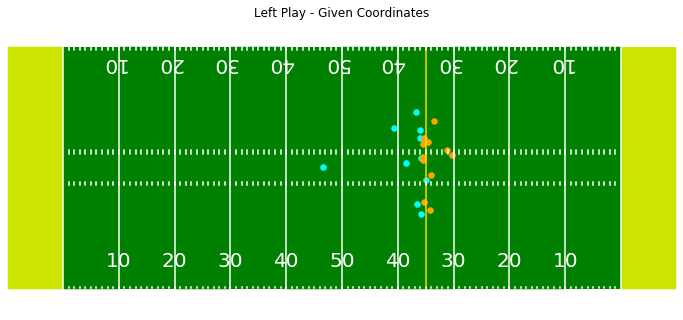

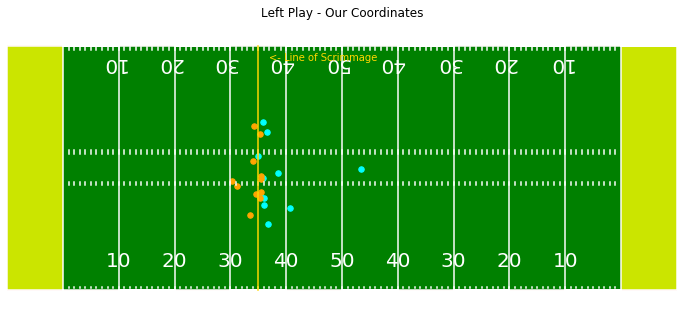

In [228]:
# plot a play
# left direction 20170907000118
# right direction 20170907000395
plot_left = data[data["playid"] == 20170907000118]
plot_right = data[data['playid'] == 20170907000395]

los_left = data.loc[data['playid'] == 20170907000118]['yardline'].tolist()[0]
los_right = data.loc[data['playid'] == 20170907000395]['yardline'].tolist()[0]
print(los_left)
###### given x and y coordinattes
fig, ax = plot_field()
#plt.subplot(4,1,1)
plot_left[plot_left['team'] == 'away'].plot(
    x = 'x',
    y = 'y', 
    kind = 'scatter', 
    ax = ax, 
    color = 'cyan',
    s = 30, 
    legend = 'Away')
# plot line of scrimmage
plt.vlines(x = 110 - los_left, ymin = 0, ymax = 53.3, color = 'gold')
#ax.legend_.remove()
#home team
plot_left[plot_left['team'] == 'home'].plot(
    x = 'x',
    y = 'y',
    kind = 'scatter',
    ax = ax,
    color = 'orange',
    s = 30,
    legend = 'Home')
plt.title('Left Play - Given Coordinates')
plt.show()

#### converted coordinates
fig1, ax1 = plot_field(highlight_los = True,
                    highlight_los_number = los_left)
#plt.subplot(4,1,2)
plot_left[plot_left['team'] == 'away'].plot(
    x = 'x_standard',
    y = 'y_standard', 
    kind = 'scatter', 
    ax = ax1, 
    color = 'cyan',
    s = 30, 
    legend = 'Away')
plot_left[plot_left['team'] == 'home'].plot(
    x = 'x_standard',
    y = 'y_standard',
    kind = 'scatter',
    ax = ax1,
    color = 'orange',
    s = 30,
    legend = 'Home')
plt.title('Left Play - Our Coordinates')
plt.show()



25


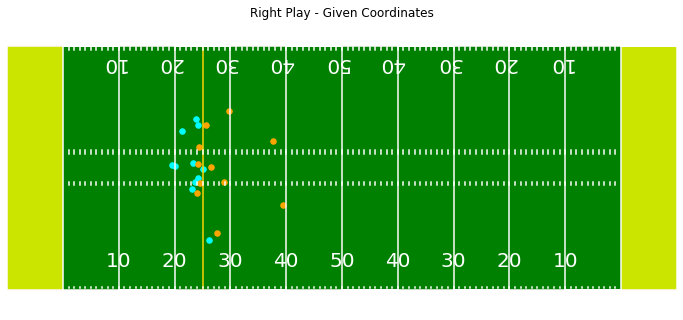

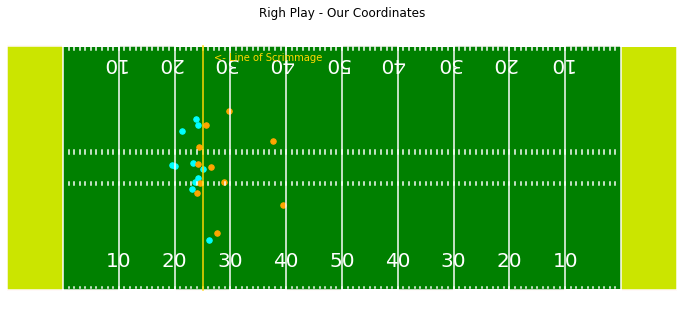

In [227]:
# plot a play
# left direction 20170907000118
# right direction 20170907000395
plot_left = data[data["playid"] == 20170907000118]
plot_right = data[data['playid'] == 20170907000395]

los_left = data.loc[data['playid'] == 20170907000118]['yardline'].tolist()[0]
los_right = data.loc[data['playid'] == 20170907000395]['yardline'].tolist()[0]
print(los_right)
###### given x and y coordinattes
fig, ax = plot_field()
#plt.subplot(4,1,1)
plot_right[plot_right['team'] == 'away'].plot(
    x = 'x',
    y = 'y', 
    kind = 'scatter', 
    ax = ax, 
    color = 'cyan',
    s = 30, 
    legend = 'Away')
# plot line of scrimmage
plt.vlines(x = 10 + los_right, ymin = 0, ymax = 53.3, color = 'gold')
#ax.legend_.remove()
#home team
plot_right[plot_right['team'] == 'home'].plot(
    x = 'x',
    y = 'y',
    kind = 'scatter',
    ax = ax,
    color = 'orange',
    s = 30,
    legend = 'Home')
plt.title('Right Play - Given Coordinates')
plt.show()

#### converted coordinates
fig1, ax1 = plot_field(highlight_los = True,
                    highlight_los_number = los_right)
#plt.subplot(4,1,2)
plot_right[plot_right['team'] == 'away'].plot(
    x = 'x_standard',
    y = 'y_standard', 
    kind = 'scatter', 
    ax = ax1, 
    color = 'cyan',
    s = 30, 
    legend = 'Away')
plot_right[plot_right['team'] == 'home'].plot(
    x = 'x_standard',
    y = 'y_standard',
    kind = 'scatter',
    ax = ax1,
    color = 'orange',
    s = 30,
    legend = 'Home')
plt.title('Righ Play - Our Coordinates')
plt.show()



In [170]:
data.loc[data['playid'] == 20170907000395]['yardline'][88]

25

In [200]:
los = data[data["playid"] == 20170907000118]['yardline'][0]
print(los)

35


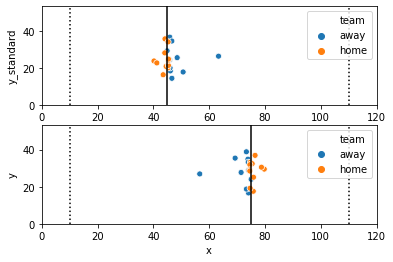

In [201]:
# explore one play visually
# influcenced by https://www.kaggle.com/statsbymichaellopez/nfl-tracking-wrangling-voronoi-and-sonars
# select one play
#fig, ax = plot_field()

plot = data[data["playid"] == 20170907000118]
# plot using seaborn
plt.subplot(2, 1, 1)
sns.scatterplot(data=plot,x="x_standard",y="y_standard",hue="team" )
plt.vlines(x = los + 10, ymin = 0, ymax = 53.3)
plt.vlines(x = 10, ymin = 0, ymax = 53.3, linestyles = ':')
plt.vlines(x = 110, ymin = 0, ymax = 53.3, linestyles = ':')
plt.xlim(0, 120)
plt.ylim(0, 53.3)
plt.subplot(2, 1, 2)
sns.scatterplot(data=plot,x="x",y="y",hue="team")
plt.vlines(x = 110 - los, ymin = 0, ymax = 53.3, label = str(110-los)) # los
plt.vlines(x = 10, ymin = 0, ymax = 53.3, linestyles = ':')
plt.vlines(x = 110, ymin = 0, ymax = 53.3, linestyles = ':')
plt.xlim(0, 120)
plt.ylim(0, 53.3)
# show plot
plt.show()
del plot

In [133]:
data.loc[(data['playid'] == 20170907000118)&(data['team'] == 'home')]

,gameid,playid,team,x,y,s,a,dis,orientation,dir,nflid,displayname,jerseynumber,season,yardline,quarter,gameclock,possessionteam,down,distance,fieldposition,homescorebeforeplay,visitorscorebeforeplay,nflidrusher,offenseformation,offensepersonnel,defendersinthebox,defensepersonnel,playdirection,timehandoff,timesnap,yards,playerheight,playerweight,playerbirthdate,playercollegename,position,hometeamabbr,visitorteamabbr,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection,age,rusher,rushx,rushy,disttorush,ol_d,dl,lb,db,rb_d,qb,ol,rb,te,wr,dl_o,lb_o,db_o,teamidentity,yardfromowngoal,x_standard,y_standard
11,2017090700,20170907000118,home,75.82,17.56,2.30,1.39,0.55,181.03,165.85,2649,Danny Amendola,80,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,71,185,1985-11-02,Texas Tech,WR,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,32,0,78.75,30.53,13.296834,0,2,3,6,0,1,5,1,1,3,0,0,0,NE,35,34.18,35.773333
12,2017090700,20170907000118,home,74.78,33.21,1.71,0.82,0.19,181.18,234.10,497240,Rob Gronkowski,87,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,78,265,1989-05-14,Arizona,TE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,28,0,78.75,30.53,4.789916,0,2,3,6,0,1,5,1,1,3,0,0,0,NE,35,35.22,20.123333
13,2017090700,20170907000118,home,75.43,32.41,1.50,1.36,0.32,152.92,227.24,2495131,Marcus Cannon,61,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,78,335,1988-05-06,Texas Christian,T,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,29,0,78.75,30.53,3.815337,0,2,3,6,0,1,5,1,1,3,0,0,0,NE,35,34.57,20.923333
14,2017090700,20170907000118,home,75.90,25.12,1.38,0.80,0.19,226.99,251.45,2495232,Nate Solder,77,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,81,325,1988-04-12,Colorado,T,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,29,0,78.75,30.53,6.114785,0,2,3,6,0,1,5,1,1,3,0,0,0,NE,35,34.10,28.213333
15,2017090700,20170907000118,home,79.76,29.49,0.84,1.22,0.00,167.82,339.14,2504211,Tom Brady,12,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,76,225,1977-08-03,Michigan,QB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,40,0,78.75,30.53,1.449724,0,2,3,6,0,1,5,1,1,3,0,0,0,NE,35,30.24,23.843333
16,2017090700,20170907000118,home,76.47,36.91,5.15,0.77,0.59,247.98,254.91,2530515,Chris Hogan,15,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,73,210,1987-10-24,"Monmouth, N.J.",WR,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,30,0,78.75,30.53,6.775161,0,2,3,6,0,1,5,1,1,3,0,0,0,NE,35,33.53,16.423333
17,2017090700,20170907000118,home,74.70,19.19,2.10,1.48,0.51,207.86,171.48,2543498,Brandin Cooks,14,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,70,183,1993-09-25,Oregon State,WR,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,24,0,78.75,30.53,12.041516,0,2,3,6,0,1,5,1,1,3,0,0,0,NE,35,35.30,34.143333
18,2017090700,20170907000118,home,78.75,30.53,3.63,3.35,0.38,198.02,204.26,2543773,James White,28,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:0

In [29]:
# this function sets what team the player is on
def teamIdentitySet(x):
    if x["team"] == "home":
        return x["hometeamabbr"]
    else:
        return x["visitorteamabbr"]
# applying function entire data df
data["teamidentity"] = data.apply(teamIdentitySet, axis=1)

In [30]:
#  create row called yards from own goal
def createYardsFromOwnGoal(x):
    # if the ball is on the possession teams side, just return yardline
    if x["fieldposition"] == x["possessionteam"]:
        return x["yardline"]
    else:
    # if the ball is not on the possesion team side, convert
        return (50 + (50-x["yardline"]))
data["yardfromowngoal"] = data.apply(createYardsFromOwnGoal,axis = 1)

In [185]:
def standardizeXCoordinates(x):
    if x["playdirection"] == "left":
        return 120 - x["x"] 
    else:
        return x["x"] 
def standardizeYCoordinates(x):
    if x["playdirection"] == "left":
        return 160/3 - x["y"]
    else:
        return x["y"]

In [186]:
data["x_standard"] = data.apply(standardizeXCoordinates,axis=1)
data["y_standard"] = data.apply(standardizeYCoordinates, axis=1)

In [233]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import cross_val_score

In [311]:
#x.select_dtypes([np.number]).head()
cols_to_drop = ['gameid', 'playid', 'x', 'y', 'orientation', 'dir', 'nflid', 
               'jerseynumber', 'season', 'nflidrusher', 'week', 'yards',
               'temperature', 'humidity', 'windspeed']

In [290]:
print(int(n_plays * (len(data)/22)))
print(len(data)/22)
print(int(len(data)/22*0.8))

2480560
31007.0
24805


In [302]:
24805 * 22 - 1 

545709

In [394]:
# define prediction and output
y = sub['yards']
x = sub.drop(cols_to_drop, axis = 1)

# one-hot encoding
x = pd.get_dummies(x)

# get only numeric variables
x = x.select_dtypes([np.number])
x = x.fillna(0)

n_plays = 80 # number of plays in the train set

cutoff = int(len(sub)/22*0.8) * 22 
print(cutoff)
Xtrain, Xtest, ytrain, ytest = x[:cutoff], x[cutoff:], y[:cutoff], y[cutoff:]

print('train x: {}'.format(Xtrain.shape))
print('test x: {}'.format(Xtest.shape))
print('train y: {}'.format(ytrain.shape))
print('test y: {}'.format(ytest.shape))

1760
train x: (1760, 473)
test x: (440, 473)
train y: (1760,)
test y: (440,)


In [313]:
x.isna().sum()

s                         0
a                         0
dis                       0
yardline                  0
quarter                   0
down                      0
distance                  0
homescorebeforeplay       0
visitorscorebeforeplay    0
defendersinthebox         0
playerheight              0
playerweight              0
age                       0
rusher                    0
rushx                     0
rushy                     0
disttorush                0
ol_d                      0
dl                        0
lb                        0
db                        0
rb_d                      0
qb                        0
rb                        0
te                        0
wr                        0
dl_o                      0
lb_o                      0
db_o                      0
yardfromowngoal           0
x_standard                0
y_standard                0
dtype: int64

In [395]:
clf = rfc(n_estimators = 100)
clf.fit(Xtrain, ytrain)
y_pred = clf.predict(Xtest)
errors = abs(y_pred - ytest)
acc = clf.score(Xtest, ytest)
print('Accuracy: %.2f' % acc)
print('Mean Absolute Error: %.2f' %errors.mean())

Accuracy: 0.19
Mean Absolute Error: 4.15


In [397]:
# reindex ytest
ytest.index = range(len(ytest))
ytest[0]

1

In [400]:
# are predictions within 1 yard?
wr = []
for i in range(len(y_pred)):
        if abs(y_pred[i] - ytest[i]) <= 1:
            wr.append(1)
        else:
            wr.append(0)
sum(wr)/len(wr)

0.39545454545454545

In [315]:
# cross validation
scores = cross_val_score(clf, x, y, cv = 3)
print(scores.mean())

0.12099906984161836


In [319]:
p = data[:1]['x_standard'] + data[:1]['s'] + data[:1]['a'] ** 2
p - data[:1]['x_standard']

0    2.9669
dtype: float64

In [339]:
# Transform stadium type
def clean_stad_type(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    #txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt
data['stadiumtype'] = data['stadiumtype'].apply(clean_stad_type)

In [342]:
# focus only on outdoor, indoor, open, and closed
def num_stad_type(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    # else
    return np.nan

data['stadiumtype'] = data['stadiumtype'].apply(num_stad_type)

In [343]:
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,nflid,displayname,jerseynumber,season,yardline,quarter,gameclock,possessionteam,down,distance,fieldposition,homescorebeforeplay,visitorscorebeforeplay,nflidrusher,offenseformation,offensepersonnel,defendersinthebox,defensepersonnel,playdirection,timehandoff,timesnap,yards,playerheight,playerweight,playerbirthdate,playercollegename,position,hometeamabbr,visitorteamabbr,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection,age,rusher,rushx,rushy,disttorush,ol_d,dl,lb,db,rb_d,qb,ol,rb,te,wr,dl_o,lb_o,db_o,teamidentity,yardfromowngoal,x_standard,y_standard
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,278.01,272.82,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,Field Turf,Clear and warm,63.0,77.0,8.0,SW,29,0,78.75,30.53,6.480872,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,46.09,18.493333
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,332.39,251.30,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,Field Turf,Clear and warm,63.0,77.0,8.0,SW,28,0,78.75,30.53,4.593310,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,45.33,20.693333
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,356.99,247.27,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,Field Turf,Clear and warm,63.0,77.0,8.0,SW,28,0,78.75,30.53,5.448982,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,46.00,20.133333
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,0.23,344.36,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,Field Turf,Clear and warm,63.0,77.0,8.0,SW,35,0,78.75,30.53,7.820038,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,48.54,25.633333
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,347.37,285.69,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,Field Turf,Clear and warm,63.0,77.0,8.0,SW,30,0,78.75,30.53,10.622476,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,50.68,17.913333
